In [1]:
cd C:\Users\ysyang\Documents\yongsoo\Teaching\2025_Spring_Comp_Physics\2D_TMD_Quantification\ToShare

C:\Users\ysyang\Documents\yongsoo\Teaching\2025_Spring_Comp_Physics\2D_TMD_Quantification\ToShare


C:\Users\ysyang\Documents\yongsoo\Teaching\2025_Spring_Comp_Physics\Anaconda\env\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
# import modules
import numpy as np
from matplotlib import pyplot as plt
import scipy as sp

import importlib

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
import time

import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

#import models_small

In [3]:
# Image Size Parameters
Dim0 = 64
Dim1 = 64
Padding = 20

# Probability of Vacancy
Vac_Prob_Mo = 0.05
Vac_Prob_S = 0.4

# Position Displacement Width(Sigma)
Position_disp_sigma = 0.02   # in Angstrom

# Atomic Structure Parameters
Lattice_const_a = 3.16   # in Angstrom
Lattice_const_c = 3.17   # in Angstrom
PixelSize = 0.15  # in Angstrom

AtomGaussSigma_Mo = 0.35 # in Angstrom
AtomGaussSigma_S = 0.5 # in Angstrom

AtomStrength_Mo = 42. # in Angstrom
AtomStrength_S = 16. # in Angstrom

AtomSigmaForClassify = 0.15 # in Angstrom

# Poisson Noise parameter
NumElectrons_ForMoMax = 8    # Number of electron count for scattering from maximum intensity pixel of Mo
                              # The smaller this number, the noisier the image

# Gaussian Noise parameter
Gaussian_Noise_mu = 7
Gaussian_Noise_sigma = 3

CropHalfWidth = 9  # in pixel

RotAngFact = np.pi * 2. / 3.  # this will apply random rotation
# RotAngFact = 0  # this will make random rotation off

batch_size = 10

In [ ]:
UC_a_range = range(0, round(Dim0*PixelSize*3 / Lattice_const_a ), 1)
UC_b_range = range(0, round(Dim1*PixelSize*3 / Lattice_const_a ), 1)

AtomPosArr = np.zeros((len(UC_a_range)*len(UC_b_range)*3,3))
AtomTypeArr = np.zeros((len(UC_a_range)*len(UC_b_range)*3,1))
AtomSigmaArr = np.zeros((len(UC_a_range)*len(UC_b_range)*3,1))

a1 = Lattice_const_a * np.array([1, 0])
a2 = Lattice_const_a * np.array([np.cos(2 * np.pi / 3), np.sin(2 * np.pi / 3)])
b = (Lattice_const_a / np.sqrt(3)) * np.array([np.cos(np.pi / 6), np.sin(np.pi / 6)])

# tile Unit Cells to create 2D crystal
for a_ind in UC_a_range:
    for b_ind in UC_b_range:
        x, y = a_ind * a1 + b_ind * a2
        AtomPosArr[a_ind*len(UC_b_range)*3+b_ind*3+0,0] = x # x of Mo
        AtomPosArr[a_ind*len(UC_b_range)*3+b_ind*3+0,1] = y # y of Mo
        AtomPosArr[a_ind*len(UC_b_range)*3+b_ind*3+0,2] = 0  # z of Mo
        AtomTypeArr[a_ind*len(UC_b_range)*3+b_ind*3+0] = 42 # Mo
        AtomSigmaArr[a_ind*len(UC_b_range)*3+b_ind*3+0] = AtomStrength_Mo # Mo

        # Do the same for two sulfur atoms in the unit cell...
        x, y = a_ind * a1 + b_ind * a2 + b
        AtomPosArr[a_ind*len(UC_b_range)*3+b_ind*3+1,0] = x # x of S
        AtomPosArr[a_ind*len(UC_b_range)*3+b_ind*3+1,1] = y # y of S
        AtomPosArr[a_ind*len(UC_b_range)*3+b_ind*3+1,2] = Lattice_const_c / 2  # z of S
        AtomTypeArr[a_ind*len(UC_b_range)*3+b_ind*3+1] = 16 # S
        AtomSigmaArr[a_ind*len(UC_b_range)*3+b_ind*3+1] = AtomStrength_S # S
        
        AtomPosArr[a_ind*len(UC_b_range)*3+b_ind*3+2,0] = x # x of S
        AtomPosArr[a_ind*len(UC_b_range)*3+b_ind*3+2,1] = y # y of S
        AtomPosArr[a_ind*len(UC_b_range)*3+b_ind*3+2,2] = -Lattice_const_c / 2  # z of S
        AtomTypeArr[a_ind*len(UC_b_range)*3+b_ind*3+2] = 16 # S
        AtomSigmaArr[a_ind*len(UC_b_range)*3+b_ind*3+2] = AtomStrength_S # S
        
 


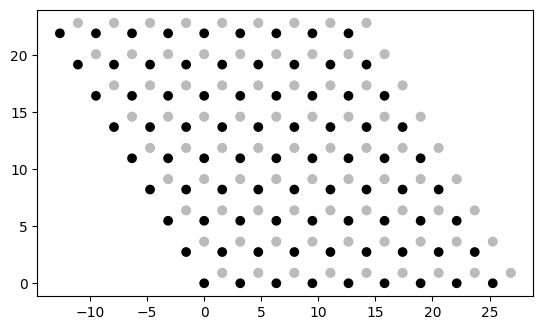

In [12]:
# check generated structure

plt.scatter(AtomPosArr[:,0], AtomPosArr[:,1], c=AtomTypeArr, cmap="Greys")
plt.axis('image')
plt.clim(0,42)
plt.show()


In [ ]:

def CreateImageFromAtomicStructure_GEN(Dim0, Dim1, AtomPosArr, AtomGaussSigma, AtomStrength, CropHalfWidth, PixelSize):
    Image = np.zeros((Dim0,Dim1))
    gGrid0, gGrid1 = np.meshgrid(np.arange(CropHalfWidth*2+1) - CropHalfWidth , np.arange(CropHalfWidth*2+1) - CropHalfWidth, indexing='ij')

    # loop through atom positions
    for atomInd in range(AtomPosArr.shape[0]):
        # crop local area near the position
        CropInd0 = np.round(np.arange(CropHalfWidth*2+1) - CropHalfWidth + np.round(AtomPosArr[atomInd,0]))
        CropInd1 = np.round(np.arange(CropHalfWidth*2+1) - CropHalfWidth + np.round(AtomPosArr[atomInd,1]))
        
        # Add 2D Guassian function to the cropped area
        Image[int(CropInd0[0]):int(CropInd0[0]+CropHalfWidth*2+1),int(CropInd1[0]):int(CropInd1[0]+CropHalfWidth*2+1)] += AtomStrength[atomInd]*np.exp( -1*((gGrid0 - (AtomPosArr[atomInd,0] - np.round(AtomPosArr[atomInd,0])))**2 + 
                                                 (gGrid1 - (AtomPosArr[atomInd,1] - np.round(AtomPosArr[atomInd,1])))**2) / 
                                                 (2* (AtomGaussSigma[atomInd]/PixelSize)**2) )

    return Image

In [ ]:
# create images based on the atomic structure and parameters
def CreateSimulatedImages(Dim0, Dim1, Padding, Lattice_const_a, AtomPosArr, AtomTypeArr, AtomSigmaArr, NumTargetImages, RotAngFact, Position_disp_sigma, CropHalfWidth, PixelSize, AtomSigmaForClassify):

    # Dim0, Dim1 : image size (# pixels) along Dim0 and Dim1
    # Padding: number of pixeles added to Dim0 and Dim1 during the image generation to eliminate edge effect
    # Lattice_const_a: hexagonal "a" lattice constant (in Angstrom)
    # AtomPosArr: Nx3 numpy array for x, y, z positions of N atoms
    # AtomTypeArr: Nx1 numpy array for atomic number for each atom
    # AtomSigmaArr: Nx1 numpy array for Gaussian width for each atom (in Angstrom)
    # NumTargetImages: number of ramdom images generated by this function
    # RotAngFact: a factor multiplied to random number between 0 and 1. Set to zero for no rotation, set to 2*pi/3 for random angle between 0 and 120 deg
    # Position_disp_sigma: standard deviation of Gaussian-distributed random displacement of atoms (in Angstrom)
    # CropHalfWidth: For efficient Gaussin calculation; only (CropHalfWidth*2+1 X CropHalfWidth*2+1) sized Gaussian will be calculated for each atom (in pixels)
    # PixelSize: size of each pixel (in Angstrom)
    # AtomSigmaForClassify:  Gaussian width for each atom for Classification ground truth images (in Angstrom)


    
    # draw random rotation angles
    rand_angle = RotAngFact * np.random.uniform(0, 1)
        
    # center position of the crystal; to be used for center of crop position
    AtomPosArr_centered = AtomPosArr - np.mean(AtomPosArr, axis=0)
    

    # prepare final image stack array variables
    SimImageArr = np.empty((NumTargetImages, Dim0, Dim1))
    SimClassImageArr = np.empty((NumTargetImages, 6, Dim0, Dim1))
    
    # prepare final atomic structure array variables   
    AtomPosFinalArrList = []
    AtomStrengthFinalArrList = []
    AtomGaussSigmaFinalArrList = []

    

    # loop through the images randomly generated
    for i in range(NumTargetImages):
        # Random shift vector up to a unit cell
        a1 = Lattice_const_a * np.array([1, 0])
        a2 = Lattice_const_a * np.array([np.cos(2 * np.pi / 3), np.sin(2 * np.pi / 3)])
        
        offset_x, offset_y = np.random.uniform(0, 1) * a1 + np.random.uniform(0, 1) * a2
        offset = np.array([offset_x, offset_y, 0])
        AtomPosArr_shifted = AtomPosArr_centered + offset[np.newaxis, :]

        # Random 2D rotation matrix
        cos = np.cos(rand_angle)
        sin = np.sin(rand_angle)
        rotation_mat = np.array([
            [cos, -sin, 0],
            [sin, cos, 0],
            [0, 0, 1]
        ])
        
        # structure after random rotation and shift
        AtomPosArr_rotated = np.einsum('nj,ij->ni', AtomPosArr_shifted, rotation_mat)

        # generous (padded size) crop for square image generation
        (minx, maxx) = ((-Padding) * PixelSize, (Dim0 + Padding) * PixelSize)
        (miny, maxy) = ((-Padding) * PixelSize, (Dim1 + Padding) * PixelSize)
        (minz, maxz) = (-np.inf, np.inf)
        x_cond = (AtomPosArr_rotated[:, 0] >= minx) & (AtomPosArr_rotated[:, 0] <= maxx)
        y_cond = (AtomPosArr_rotated[:, 1] >= miny) & (AtomPosArr_rotated[:, 1] <= maxy)
        z_cond = (AtomPosArr_rotated[:, 2] >= minz) & (AtomPosArr_rotated[:, 2] <= maxz)
        
        valid_cond = x_cond & y_cond & z_cond
        
        # atomic structure after generous cropping
        
        AtomPosArr_cropped = AtomPosArr_rotated[valid_cond]
        AtomTypeArr_cropped = AtomTypeArr[valid_cond]
        AtomSigmaArr_cropped = AtomSigmaArr[valid_cond]

        # random removal of atoms for vacancy formation based on given probability
        survived = np.full((AtomPosArr.shape[0],), True)
        rands = np.random.uniform(0, 1, (AtomPosArr.shape[0],))
        Mo = 42
        S = 16
        survived_Mo = ((AtomTypeArr_cropped == Mo) & rands > Vac_Prob_Mo)
        survived_S = ((AtomTypeArr_cropped == S) & rands > Vac_Prob_S)
        survived = survived_Mo | survived_S

        # T/F boolean for killed Mo atoms

        
        # T/F boolean for killed S atoms

        
        # Indices for killed S atoms
        

        # T/F boolean array for identifying positions of double vacancy (both S atoms are killed at a S atom site)

        

        # loop through killed S atom indices to identify the position of double vacancy (both S atoms are killed at a S atom site)

        

        # T/F boolean array for identifying positions of S atoms at which either one of the S atom is killed

        

        # loop through killed S atom indices to identify the position of S positions for single and double vacancy

        

        # T/F boolean for killed S atoms forming double vacancy

        

        # T/F boolean for killed S atoms forming single vacancy

        AtomPosArr_survived = AtomPosArr_rotated[survived]
        AtomTypeArr_survived = AtomTypeArr[survived]
        AtomSigmaArr_survived = AtomSigmaArr[survived]
        
        
        # Gaussian strength (intensity of atoms) for Mo atoms
        
        
             
        # Gaussian strength (intensity of atoms) for S atoms (no vacancy)

        
        # Gaussian strength (intensity of atoms) for S atoms with single vacancy

        

        # Gaussian strength (intensity of atoms) double vacancy S sites

        

        # Gaussian strength (intensity of atoms) for Mo vacancy sites


        
        # Gaussian Sigma array for Classification ground truth images

        
        # make the strength of killed atoms to be zero for image generation
        
        
        #AtomPosArr  = np.delete(AtomPosArr, SurviveInd[:,0], axis=0)
        #AtomTypeArr = np.delete(AtomTypeArr, SurviveInd[:,0], axis=0)
        #AtomSigmaArr = np.delete(AtomSigmaArr, SurviveInd[:,0], axis=0)        

        # add random displacement from Gaussin distribution based on "Position_disp_sigma"
        displacements = np.random.normal(0, Position_disp_sigma, AtomPosArr_survived.shape)
        AtomPosArr_survived += displacements
        
        # create atomic structure image
        image = np.zeros((0, Dim0, ))
        n_atoms = 
        AtomPosArr_survived = 
        AtomTypeArr_survived = 
        AtomSigmaArr_survived = 
        
        
        # create classification ground truth images for each class

 

        # unpad the images to the size of (Dim0, Dim1)

        
        # store in the array


        # apply hard cropping to the atomic structures to be returned
        

        # store in the python list
        
        
        
    return SimImageArr, SimClassImageArr, AtomPosFinalArrList, AtomStrengthFinalArrList, AtomGaussSigmaFinalArrList

In [8]:
# Create training, validation, test dataset

TrainingImages, TrainingClassImages, TrainingAtomPosFinalArrList, TrainingAtomStrengthFinalArrList, TrainingAtomGaussSigmaFinalArrList = CreateSimulatedImages(Dim0, Dim1, Padding, Lattice_const_a, AtomPosArr, AtomTypeArr, AtomSigmaArr, NumTrainingSets, RotAngFact, Position_disp_sigma, CropHalfWidth, PixelSize, AtomSigmaForClassify )
ValidationImages, ValidationClassImages, ValidationAtomPosFinalArrList, ValidationAtomStrengthFinalArrList, ValidationAtomGaussSigmaFinalArrList = CreateSimulatedImages(Dim0, Dim1, Padding, Lattice_const_a, AtomPosArr, AtomTypeArr, AtomSigmaArr, NumValidationSets, RotAngFact, Position_disp_sigma, CropHalfWidth, PixelSize, AtomSigmaForClassify )
TestImages, TestClassImages, TestAtomPosFinalArrList, TestAtomStrengthFinalArrList, TestAtomGaussSigmaFinalArrList = CreateSimulatedImages(Dim0, Dim1, Padding, Lattice_const_a, AtomPosArr, AtomTypeArr, AtomSigmaArr, NumTestSets, RotAngFact, Position_disp_sigma, CropHalfWidth, PixelSize, AtomSigmaForClassify )




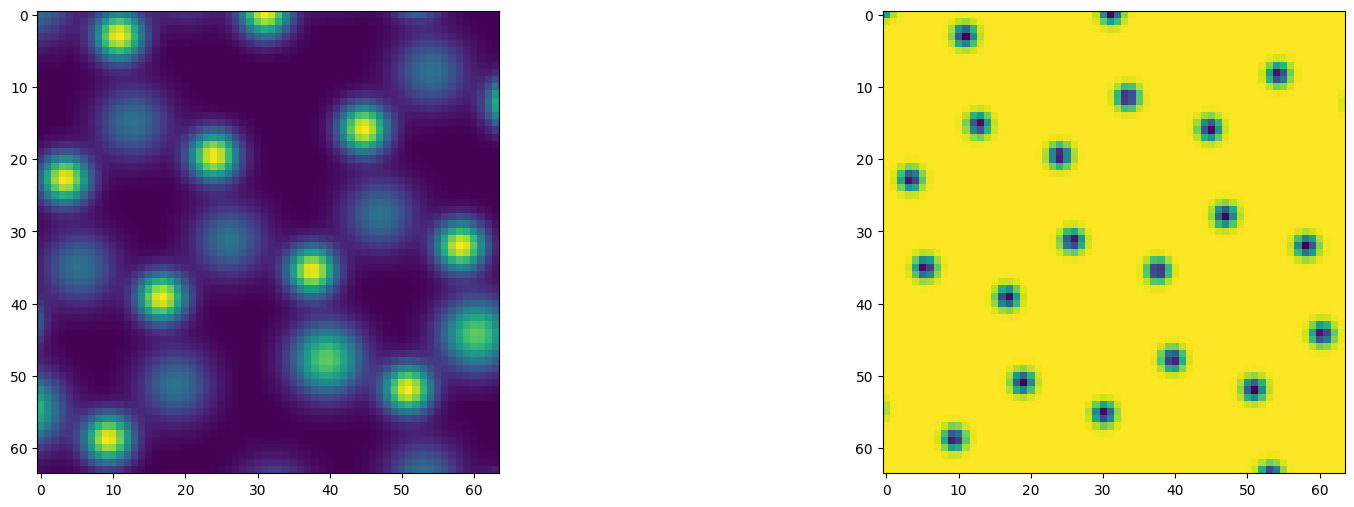

In [10]:
# check classification GT Class layers
AA = 2
CheckClass = 5

f = plt.figure(figsize=(20,6))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax.imshow(TestImages[:,:,AA])
ax2.imshow(TestClassImages[:,:,CheckClass,AA])


In [12]:
# For preparing neural network input

class CustomNumpyDataset(Dataset):
    def __init__(self, numpy_DataArray, numpy_GTArray, transform=None):
        self.numpy_DataArray = numpy_DataArray
        self.numpy_GTArray = numpy_GTArray
        self.transform = transform

    def __len__(self):
        return self.numpy_DataArray.shape[2]

    def __getitem__(self, idx):
        input_data = self.numpy_DataArray[:,:,idx]
        input_data = input_data.reshape((1,self.numpy_DataArray.shape[0],self.numpy_DataArray.shape[1]))
        input_data = torch.from_numpy(input_data)

        target_data = self.numpy_GTArray[:,:,idx]
        target_data = target_data.reshape((1,self.numpy_GTArray.shape[0],self.numpy_GTArray.shape[1]))
        target_data = torch.from_numpy(target_data)        
        
        if self.transform:
            input_data, target_data = self.transform(input_data, target_data)
        
        return input_data, target_data

In [13]:
# For preparing neural network input

class CustomNumpyClassificationDataset(Dataset):
    def __init__(self, numpy_DataArray, numpy_GTArray, transform=None):
        self.numpy_DataArray = numpy_DataArray
        self.numpy_GTArray = numpy_GTArray
        self.transform = transform

    def __len__(self):
        return self.numpy_DataArray.shape[2]

    def __getitem__(self, idx):
        input_data = self.numpy_DataArray[:,:,idx]
        input_data = input_data.reshape((1,self.numpy_DataArray.shape[0],self.numpy_DataArray.shape[1]))
        input_data = torch.from_numpy(input_data)

        target_data = self.numpy_GTArray[idx,:,:,:]
        target_data = target_data.reshape((1,6,self.numpy_GTArray.shape[2],self.numpy_GTArray.shape[3]))
        target_data = torch.from_numpy(target_data)        
        
        if self.transform:
            input_data, target_data = self.transform(input_data, target_data)
        
        return input_data, target_data

In [14]:
### checking that cuda is available or not ###
USE_CUDA=torch.cuda.is_available()
DEVICE=torch.device("cuda" if USE_CUDA else "cpu")
print("CUDA: {}".format(USE_CUDA))
###


CUDA: False


In [15]:
# TrainingImages = np.load("TrainingImages.npy")
# ValidationImages = np.load("ValidationImages.npy")
# TestImages = np.load("TestImages.npy")

AtomStrength_Mo = 42. # in Angstrom
AtomStrength_S = 16. # in Angstrom


# Add Poisson noise
TrainingImages_Noised = np.random.poisson(TrainingImages / np.max(TrainingImages) * NumElectrons_ForMoMax ) * np.max(TrainingImages) / NumElectrons_ForMoMax  # noisy image
ValidationImages_Noised = Similar
TestImages_Noised = Similar

# Add Gaussian noise
TrainingImages_Noised += np.random.normal(Gaussian_Noise_mu, Gaussian_Noise_sigma, TrainingImages_Noised.shape)
ValidationImages_Noised +=  Similar
TestImages_Noised += Similar



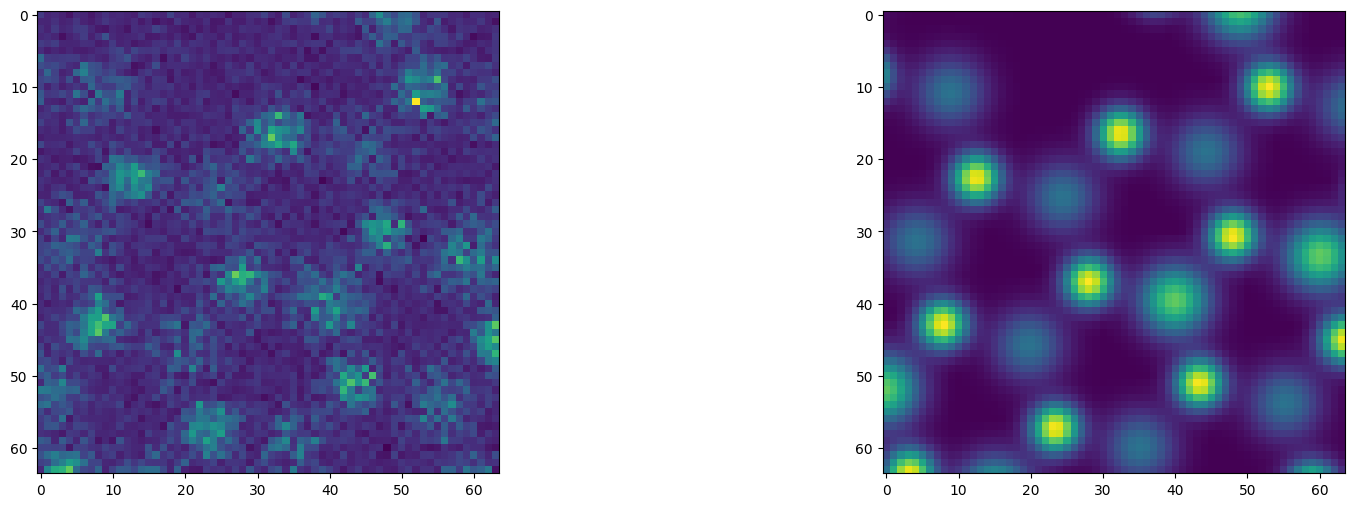

In [16]:
# check generated images

AA = 1

f = plt.figure(figsize=(20,6))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax.imshow(TrainingImages_Noised[:,:,AA])
ax2.imshow(TrainingImages[:,:,AA])


In [18]:
# denoising network training data initialization

params2 = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 0}
#params3 = {'batch_size': 1, 'shuffle': True, 'num_workers': 0}


train_dataset = CustomNumpyDataset(TrainingImages_Noised, TrainingImages)
validation_dataset = CustomNumpyDataset(ValidationImages_Noised, ValidationImages)
test_dataset = CustomNumpyDataset(TestImages_Noised, TestImages)

train_generator = DataLoader(train_dataset, **params2)
validation_generator = DataLoader(validation_dataset, **params2)
test_generator = DataLoader(test_dataset, **params2)



In [21]:
denoising_model = models_small.DenoisingNet()

## Train the neural network  yourself !!! ###


### load the result ###
PATH = './DenoisingResult'
denoising_model.load_state_dict(torch.load(PATH, map_location={'cuda:0': 'cpu'}))

print('loading model: OK!')
###

loading model: OK!


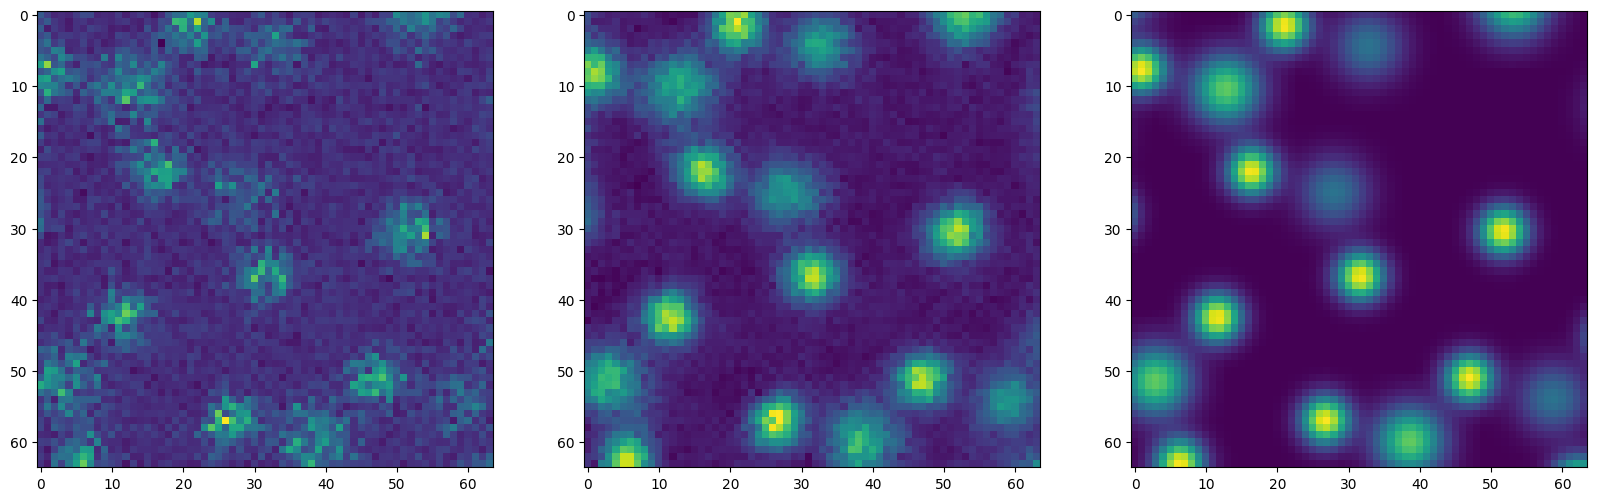

In [22]:
# Check the inference of trained network

i = 5

input_data = TestImages_Noised[:,:,i]
GT_data = TestImages[:,:,i]

with torch.no_grad():
    inputs = torch.tensor(input_data.reshape(1,input_data.shape[0],input_data.shape[1])).view(-1,1,Dim0, Dim1).float().to(DEVICE)
    
    outputs1 = denoising_model(inputs)
    outputs = outputs1.data[0][0].cpu().numpy()

f = plt.figure(figsize=(20,6))
ax = f.add_subplot(131)
ax2 = f.add_subplot(132)
ax3 = f.add_subplot(133)

ax.imshow(input_data)
ax2.imshow(outputs)
ax3.imshow(GT_data)

In [23]:
# classification network training data initialization

params2 = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 0}


train_dataset_classification = CustomNumpyClassificationDataset(TrainingImages, np.transpose(TrainingClassImages, (3, 2, 0, 1)))
validation_dataset_classification = CustomNumpyClassificationDataset(ValidationImages, np.transpose(ValidationClassImages, (3, 2, 0, 1)))
test_dataset_classification = CustomNumpyClassificationDataset(TestImages, np.transpose(TestClassImages, (3, 2, 0, 1)))

train_generator_classification = DataLoader(train_dataset_classification, **params2)
validation_generator_classification = DataLoader(validation_dataset_classification, **params2)
test_generator_classification = DataLoader(test_dataset_classification, **params2)

In [30]:
# classification network loading
classification_model_inf = models_small.UNet(n_channels = 1, n_classes = 6, bilinear = True)

## Train the neural network yourself !!! ###

### load the result ###
PATH = './ClassificationResult'
classification_model_inf.load_state_dict(torch.load(PATH, map_location={'cuda:0': 'cpu'}))

print('loading model: OK!')
###


loading model: OK!


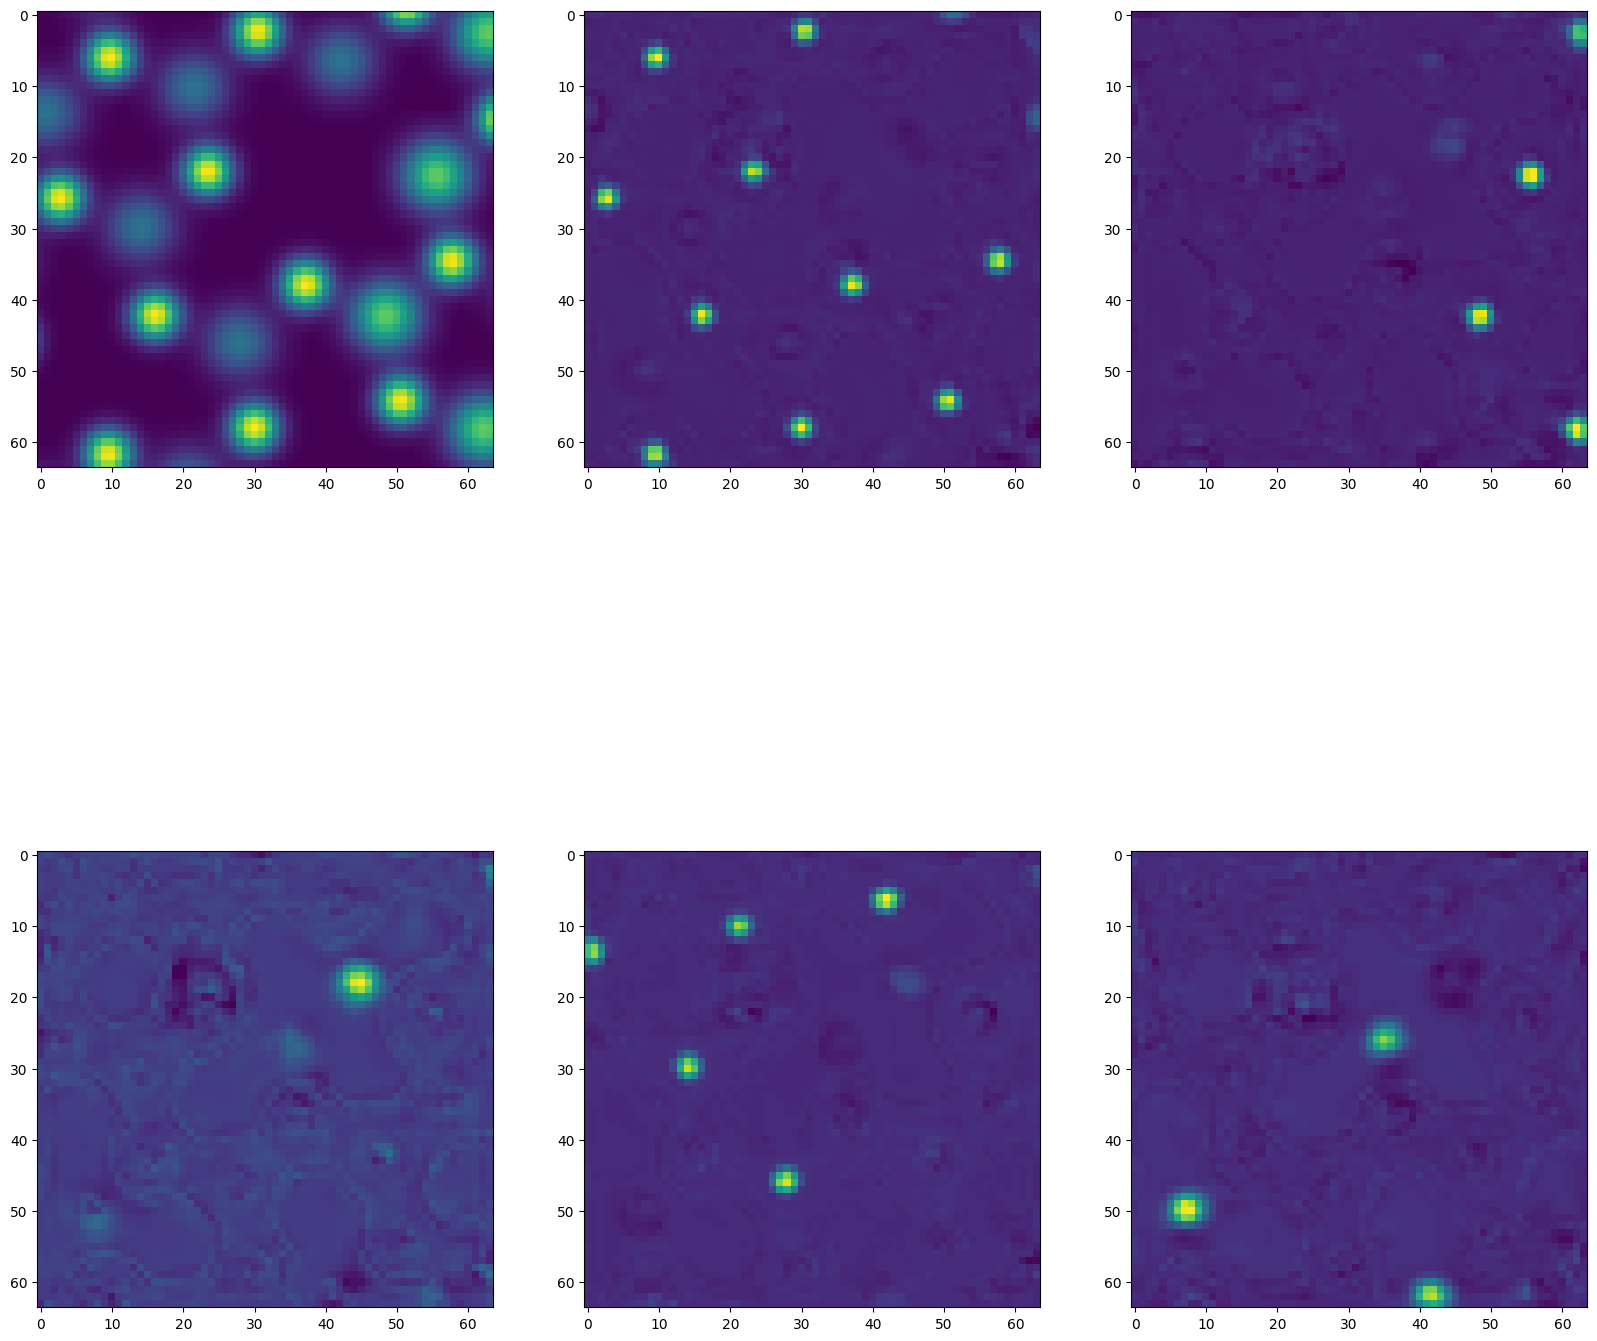

In [31]:
# Check the inference of trained network for classification

i = 807

input_data = TrainingImages[:,:,i]
GT_data = TrainingClassImages[:,:,:,i]

with torch.no_grad():
    inputs = torch.tensor(input_data.reshape(1,input_data.shape[0],input_data.shape[1])).view(-1,1,Dim0, Dim1).float().to(DEVICE)
    
    outputs1 = classification_model_inf(inputs)
    outputs = outputs1.data[0].cpu().numpy()

f = plt.figure(figsize=(20,20))
ax = f.add_subplot(231)
ax2 = f.add_subplot(232)
ax3 = f.add_subplot(233)
ax4 = f.add_subplot(234)
ax5 = f.add_subplot(235)
ax6 = f.add_subplot(236)

ax.imshow(input_data)
ax2.imshow(outputs[0,:,:])
ax3.imshow(outputs[1,:,:])
ax4.imshow(outputs[2,:,:])
ax5.imshow(outputs[3,:,:])
ax6.imshow(outputs[4,:,:])